In [44]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms

Load Training Data ~ 300 images

In [45]:
#Required size for input channels is 299 * 299 
transform = transforms.Compose([transforms.Resize(299),
                                transforms.CenterCrop(299),
                                transforms.ToTensor()])
train_dataset = datasets.ImageFolder(
        'dataset/train_images',
        transform=transform)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=1)

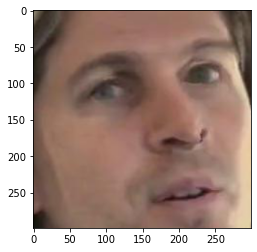

In [46]:
#Testing face load with first image
import matplotlib.pyplot as plt
images, labels = next(iter(train_dataloader))
plt.imshow(images[0].permute(1, 2, 0))

Defining custom class for xception model

In [ ]:
class Xception_Net(nn.Module):
    def __init__(
        self,
        num_classes: int = 100,
    ) -> None:
        super(Xception_Net, self).__init__()
        
        #Entry flow layer 1
        self.entry_flow_1 = nn.Sequential(
            #input channels for images is 3
            nn.Conv2d(3, 32, kernel_size = (3, 3), stride = (2, 2), padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace = True),
            
            nn.Conv2d(32, 64, kernel_size = (3, 3), padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace = True)
        )
        
        #Entry flow layer 2 - Separable convolution layer
        self.entry_flow_2_sep_conv = nn.Sequential(
            #performing depthwise and pointwise convolutions
            nn.Conv2d(64, 128, kernel_size = (3, 3), padding=1),
            nn.Conv2d(128, 128, kernel_size = (1, 1)),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace = True),
            
            nn.Conv2d(128, 128, kernel_size = (3, 3), padding=1),
            nn.Conv2d(128, 128, kernel_size = (1, 1)),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size = (3, 3), stride = (2, 2), padding=1)
            
        )
        
        #Entry flow layer 2 - Residual Convoltuional layer
        self.entry_flow_2_residual = nn.Sequential(
            #with kernel size 1, padding is set to default 0
            nn.Conv2d(64, 128, kernel_size = (1, 1), stride = (2, 2))    
        )
        
        #Entry flow layer 3 - Separable convolution layer
        self.entry_flow_3_sep_conv = nn.Sequential(
            #performing depthwise and pointwise convolutions
            nn.ReLU(inplace = True),
            nn.Conv2d(128, 256, kernel_size = (3, 3), padding=1),
            nn.Conv2d(256, 256, kernel_size = (1, 1)),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace = True),
            
            nn.Conv2d(256, 256, kernel_size = (3, 3), padding=1),
            nn.Conv2d(256, 256, kernel_size = (1, 1)),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size = (3, 3), stride = (2, 2), padding=1)
            
        )
        
        #Entry flow layer 3 - Residual Convoltuional layer
        self.entry_flow_3_residual = nn.Sequential(
            #with kernel size 1, padding is set to default 0
            nn.Conv2d(128, 256, kernel_size = (1, 1), stride = (2, 2)),
            nn.BatchNorm2d(256)
        )
        
        #Entry flow layer 4 - Separable convolution layer
        self.entry_flow_4_sep_conv = nn.Sequential(
            nn.ReLU(inplace = True),
            nn.Conv2d(256, 728, kernel_size = (3, 3), padding=1),
            nn.Conv2d(728, 728, kernel_size = (1, 1)),
            nn.BatchNorm2d(728),
            nn.ReLU(inplace = True),
            
            nn.Conv2d(728, 728, kernel_size = (3, 3), padding=1),
            nn.Conv2d(728, 728, kernel_size = (1, 1)),
            nn.BatchNorm2d(728),
            nn.MaxPool2d(kernel_size = (3, 3), stride = (2, 2), padding=1)
            
        )
        
        #Entry flow layer 4 - Residual Convoltuional layer
        self.entry_flow_4_residual = nn.Sequential(
            #with kernel size 1, padding is set to default 0
            nn.Conv2d(256, 728, kernel_size = (1, 1), stride = (2, 2)),
            nn.BatchNorm2d(728)
        )
        
        ######## Middle Flow ##########
        # 3 separable convolution layers
        self.middle_flow = nn.Sequential(
            nn.ReLU(inplace = True),
            nn.Conv2d(728, 728, kernel_size = (3, 3), padding = 1),
            nn.Conv2d(728, 728, kernel_size = (1, 1)),
            nn.BatchNorm2d(728),
            
            nn.ReLU(inplace = True),
            nn.Conv2d(728, 728, kernel_size = (3, 3), padding = 1),
            nn.Conv2d(728, 728, kernel_size = (1, 1)),
            nn.BatchNorm2d(728),
            
            nn.ReLU(inplace = True),
            nn.Conv2d(728, 728, kernel_size = (3, 3), padding = 1)
            nn.Conv2d(728, 728, kernel_size = (1, 1)),
            nn.BatchNorm2d(728)
        )
        
        ######## Exit Flow #########
        #Exit flow layer 1 - Separable convolution layer
        self.exit_flow_1_sep_conv = nn.Sequential(
            nn.ReLU(inplace = True),
            nn.Conv2d(728, 728, kernel_size = (3, 3), padding = 1),
            nn.Conv2d(728, 728, kernel_size = (1, 1)),
            nn.BatchNorm2d(728),
            
            nn.ReLU(inplace = True),
            nn.Conv2d(728, 1024, kernel_size = (3, 3), padding = 1),
            nn.Conv2d(1024, 1024, kernel_size = (1, 1)),
            nn.BatchNorm2d(1024),
            nn.MaxPool2d(kernel_size = (3, 3), stride = (2, 2), padding=1)
        )
        
        #Exit flow layer 1 - Residual Convoltuional layer
        self.exit_flow_1_residual = nn.Sequential(
            #with kernel size 1, padding is set to default 0
            nn.Conv2d(728, 1024, kernel_size = (1, 1), stride = (2, 2)),
            nn.BatchNorm2d(1024)
        )
        
        #Exit flow layer 2 - Separable convolution layer
        self.exit_flow_2_sep_conv = nn.Sequential(
            nn.Conv2d(1024, 1536, kernel_size = (3, 3), padding = 1),
            nn.Conv2d(1536, 1536, kernel_size = (1, 1)),
            nn.BatchNorm2d(1536),
            nn.ReLU(inplace = True),
            
            nn.Conv2d(1536, 2048, kernel_size = (3, 3), padding = 1),
            nn.Conv2d(2048, 2048, kernel_size = (1, 1)),
            nn.BatchNorm2d(2048),
            nn.ReLU(inplace = True),
            
            #global average pooling
            nn.AdaptiveAvgPool2d()
            
            #final linear layer
            nn.Linear(2048, num_classes)
        )
        

        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        #entry flow
        x = self.entry_flow_1(x)
        x = self.entry_flow_2_sep_conv(x) + self.entry_flow_2_residual(x)
        x = self.entry_flow_3_sep_conv(x) + self.entry_flow_3_residual(x)
        x = self.entry_flow_4_sep_conv(x) + self.entry_flow_4_residual(x)

        #middle flow is repeated 8 times
        for i in range(8):
            x = self.middle_flow(x)
        
        #exit flow
        x = self.exit_flow_1_sep_conv(x) + self.exit_flow_1_residual(x)
        x = self.exit_flow_2_sep_conv(x)
        
        return x
        